In [46]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [15]:
torch.manual_seed(42)
np.random.seed(42)

In [17]:
transform = transforms.Compose([transforms.ToTensor()])

In [31]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

100%|██████████| 26.4M/26.4M [00:09<00:00, 2.75MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 401kB/s]
100%|██████████| 4.42M/4.42M [00:03<00:00, 1.27MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 67.1kB/s]


In [32]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [33]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # Input: [1, 28, 28]
        # Свёртка №1: из 1 входного канала делает 32 карты признаков ядром 3×3.
        self.conv1 = nn.Conv2d(1, 32, 3)  # Output: [32, 26, 26]
        
        # Input: [32, 26, 26]
        # Свёртка №2: из 32 каналов делает 64 карты признаков ядром 3×3.
        self.conv2 = nn.Conv2d(32, 64, 3) # Output: [64, 11, 11]
        
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Flattening: [batch_size, 64*5*5]
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Input: [1, 28, 28]
        x = F.relu(self.conv1(x))
        # Shape: [32, 26, 26]
        x = F.max_pool2d(x, 2)
        # Shape: [32, 13, 13]
        
        x = F.relu(self.conv2(x))
        # Shape: [64, 11, 11]
        x = F.max_pool2d(x, 2)
        # Shape: [64, 5, 5]
        
        x = x.view(-1, 64 * 5 * 5) # Flattening
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [34]:
model = BasicCNN().to(device)

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [51]:
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        
        # Очистка градиента после предыдущей итерации
        optimizer.zero_grad()
        
        # Прямой проход (Forward pass)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Обратный проход (Backward pass)
        loss.backward()
        
        # Обновление параметров
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

Epoch [1/5], Loss: 0.1116
Epoch [2/5], Loss: 0.1089
Epoch [3/5], Loss: 0.1063
Epoch [4/5], Loss: 0.0986
Epoch [5/5], Loss: 0.0975


In [54]:
model.eval()
correct, total = 0, 0

all_preds = []
all_labels = []

In [58]:
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.90


In [56]:
print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.81      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.85      0.85      0.85      1000
       Dress       0.90      0.89      0.89      1000
        Coat       0.83      0.84      0.83      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.70      0.75      0.72      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



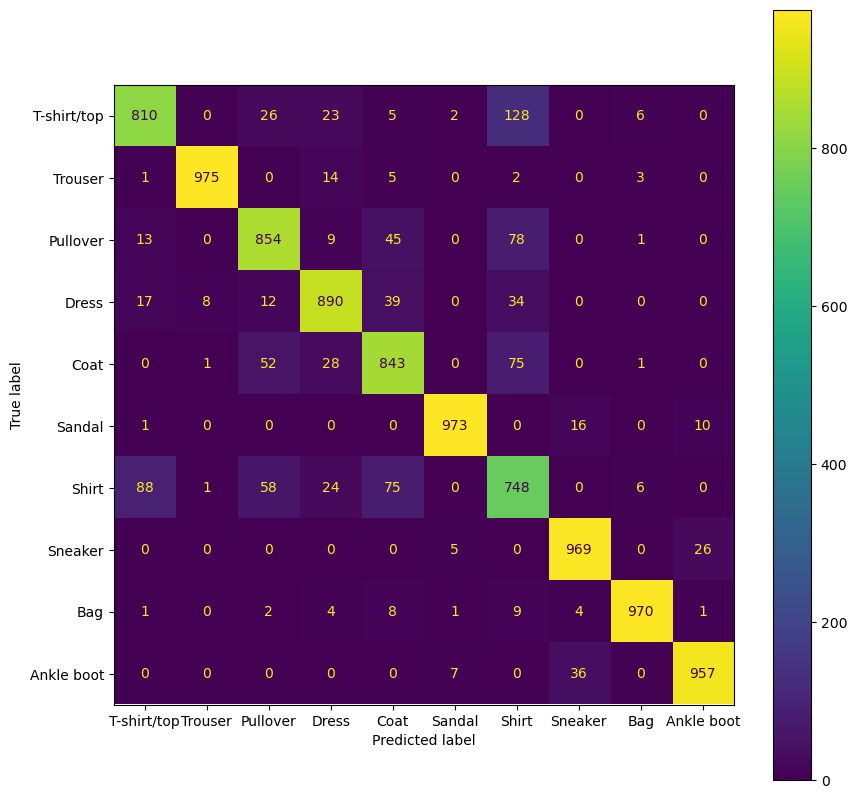

In [57]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.show()

In [60]:
model.to(device)

BasicCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Базовая CNN с двумя свёртками и двумя пулингами показала 90% точности.

Проверим, как влияет уменьшение pooling

In [71]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Input: [1, 28, 28]
        x = F.relu(self.conv1(x)) # Output: [32, 28, 28]
        x = self.pool(x) # Output: [32, 14, 14]
        x = F.relu(self.conv2(x))
        
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [72]:
model = BasicCNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        
        # Очистка градиента после предыдущей итерации
        optimizer.zero_grad()
        
        # Прямой проход (Forward pass)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Обратный проход (Backward pass)
        loss.backward()
        
        # Обновление параметров
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

model.eval()
correct, total = 0, 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2f}")

Epoch [1/5], Loss: 0.3682
Epoch [2/5], Loss: 0.2471
Epoch [3/5], Loss: 0.2020
Epoch [4/5], Loss: 0.1676
Epoch [5/5], Loss: 0.1440
Test Accuracy: 0.91


1 pooling + padding = 1

Accuracy вырос с 0.90 до 0.91, но Loss тоже вырос с 0.0975 до 0.1440. Это можно объяснить тем, что мы убрали второй пулинг, а значит сеть сохранила больше деталей и чаще правильно определяет класс. Но предсказания стали менее уверенными.

Попробуем вовсе убрать паддинг.

In [73]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=0)

        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        
        self.fc1 = nn.Linear(64 * 11 * 11, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Input: [1, 28, 28]
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [75]:
model = BasicCNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        
        # Очистка градиента после предыдущей итерации
        optimizer.zero_grad()
        
        # Прямой проход (Forward pass)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Обратный проход (Backward pass)
        loss.backward()
        
        # Обновление параметров
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

model.eval()
correct, total = 0, 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2f}")

Epoch [1/5], Loss: 0.3719
Epoch [2/5], Loss: 0.2457
Epoch [3/5], Loss: 0.1975
Epoch [4/5], Loss: 0.1662
Epoch [5/5], Loss: 0.1408
Test Accuracy: 0.91
